### Google Colab

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install pyts

     |████████████████████████████████| 2.5MB 8.5MB/s 


In [2]:
# for data analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from collections import Counter
from numpy import genfromtxt
from imblearn.under_sampling import RandomUnderSampler

# for pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from pyts.preprocessing import InterpolationImputer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin

# for training
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import expon, reciprocal
from imblearn.over_sampling import SMOTE

# for models
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression 
import lightgbm as lgb
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
import joblib

# for evaluation
from sklearn.metrics import classification_report, r2_score
from sklearn.metrics import roc_curve
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import plot_roc_curve
from keras.models import load_model
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

# etc.
import warnings
tf.debugging.set_log_device_placement(False)
warnings.filterwarnings(action='ignore')

***
# 1. 변수 제거 및 추가

### (Remind)
#### Step 1. 변수 제거
- 분석에 불필요한 변수: ['기준년도, '가입자일련번호', '데이터공개일자']
- 변수값이 존재하지 않는 변수 : ['결손치유무', '치아마모증유무', '제3대구치(사랑니)이상']

#### Step 2. 시스템적 오류값(error value) 처리
- 식전혈당(공복혈당)의 Nan값 제거: 11,914개
- 연령대코드(5세단위)는 40세 이상부터 고려
- 치석 변수의 2는 정의되지 않은 값

#### Step 3. 활용가능한 변수 추가
- 기존 데이터 변수에서 당뇨와 관련된 새로운 변수 도출이 가능한 경우에 변수 추가
- 추가한 변수: BMI(=체중 / 신장^2), 수도권([서울, 경기] = 1 / [그 외] = 0)

### (New)
#### Step 4. 중간발표 결과 응용
- 중간발표 때 확인했던 중요 변수들을 선별
- 종류: BMI, 요단백, 연령대코드(5세단위), 흡연상태, 치석, 허리둘레, 혈색소, 감마지티피, (혈청지오티)ALT, 수축기혈압, 트리글리세라이드, 시력(좌,우), 성별코드, 수도권, 구강검진수검여부

In [ ]:
'''
# dataset head
#df_2017 = pd.read_csv('/content/drive/My Drive/Course/2020년 2학기/헬스케어데이터사이언스(이동호교수님)/pbl/NHIS_2017_2018_100m/NHIS_OPEN_GJ_2017_100.csv', encoding='euc-kr')
#df_2018 = pd.read_csv('/content/drive/My Drive/Course/2020년 2학기/헬스케어데이터사이언스(이동호교수님)/pbl/NHIS_2017_2018_100m/NHIS_OPEN_GJ_2018_100.csv', encoding='utf-8')
df_2017 = pd.read_csv('G:/내 드라이브/Course/2020년 2학기/헬스케어데이터사이언스(이동호교수님)/pbl/NHIS_2017_2018_100m/NHIS_OPEN_GJ_2017_100.csv', encoding='euc-kr')
df_2018 = pd.read_csv('G:/내 드라이브/Course/2020년 2학기/헬스케어데이터사이언스(이동호교수님)/pbl/NHIS_2017_2018_100m/NHIS_OPEN_GJ_2018_100.csv', encoding='utf-8')
raw_df = pd.concat([df_2017, df_2018])

# drop features
raw_df = raw_df.drop(columns=['기준년도', '가입자일련번호', '결손치유무', '치아마모증유무', '제3대구치(사랑니)이상', '데이터공개일자']) 

# handle error value
raw_df = raw_df[raw_df['연령대코드(5세단위)'] > 8] # remove age under 40
raw_df = raw_df[raw_df['치석'] != 2] # remove value 2 in '치석'
raw_df = raw_df.dropna(subset = ['식전혈당(공복혈당)'])

# append new columns
raw_df['BMI'] = raw_df['체중(5Kg단위)'] / (raw_df['신장(5Cm단위)'] ** 2)
raw_df.loc[(raw_df['시도코드'] == 11) ^ (raw_df['시도코드'] == 41), '수도권'] = 1 
raw_df.loc[(raw_df['시도코드'] != 11) & (raw_df['시도코드'] != 41), '수도권'] = 0 

# generate classification target feature
raw_df.loc[raw_df['식전혈당(공복혈당)'] >= 126, '당뇨병'] = 1
raw_df.loc[raw_df['식전혈당(공복혈당)'] < 126, '당뇨병'] = 0

# drop continuous blood-sugar feature
raw_df = raw_df.drop(columns=['식전혈당(공복혈당)']) 

# select features from our mid-term presentation results
raw_df = raw_df[['BMI', '요단백', '연령대코드(5세단위)', '흡연상태', '치석', '허리둘레', '혈색소', '감마지티피', '(혈청지오티)ALT', '수축기혈압',
                '트리글리세라이드', '시력(우)', '시력(좌)', '성별코드', '수도권', '구강검진수검여부', '당뇨병']]

# result
raw_df = raw_df.reset_index(drop=True)
print(raw_df.shape)
raw_df.head()
'''

(1457980, 17)


,BMI,요단백,연령대코드(5세단위),흡연상태,치석,허리둘레,혈색소,감마지티피,(혈청지오티)ALT,수축기혈압,트리글리세라이드,시력(우),시력(좌),성별코드,수도권,구강검진수검여부,당뇨병
0,0.002755,1.0,9,1.0,NaN,91.0,15.8,68.0,32.0,120.0,104.0,1.5,1.2,1,1.0,0,0.0
1,0.002612,1.0,11,1.0,0.0,91.0,17.6,18.0,34.0,145.0,106.0,1.2,1.5,1,0.0,1,0.0
2,0.002204,1.0,11,1.0,0.0,80.0,13.8,25.0,12.0,138.0,104.0,1.2,1.0,1,0.0,1,0.0
3,0.002444,1.0,10,1.0,NaN,69.0,12.3,12.0,12.0,101.0,75.0,0.4,0.5,2,0.0,0,0.0
4,0.002595,1.0,12,1.0,1.0,84.0,15.1,26.0,23.0,145.0,100.0,0.9,1.2,1,1.0,1,0.0


***
# 2. 변환 파이프라인

#### Step 1. 데이터셋을 훈련 및 테스트 세트으로 분리
- 테스트셋은 전체의 20%

#### Step 2. 결측값(missing value) 처리
- 범주형 변수에서 시도코드를 제외한 나머지 특성들은 순위척도로 이해가능
- 시도코드는 평균, 나머지는 보간법으로 학습
- __테스트 세트의 결측값도 훈련 세트에서 학습된 값으로 변경__

#### Step 4. 특성 스케일링
- 특성 범위를 표준화(standardization)

#### Step 3. 클래스 불균형 해결을 위한 오버/언더샘플링
1. 훈련 세트(오버샘플링)
- 당뇨병인 클래스(1) 샘플수를 늘려서 당뇨병이 아닌 클래스(0)의 샘플수와 맞춤
- 오버샘플링 방법 중 하나인 SMOTE를 사용
2. 테스트 세트(언더샘플링)

In [ ]:
# 중간발표 특성 사용시
'''
# split train, test set
train_set, test_set = train_test_split(raw_df, test_size = .2, random_state=42, stratify = raw_df['당뇨병'])

# split X, y dataset
X_train = train_set.drop(columns=['당뇨병']) 
y_train = train_set['당뇨병']
X_raw_test = test_set.drop(columns=['당뇨병'])
y_raw_test = test_set['당뇨병']

# test set undersampling 
rus = RandomUnderSampler(random_state=42)
X_test, y_test = rus.fit_resample(X_raw_test, y_raw_test)

print("shape of raw train_set: ", X_train.shape, Counter(y_train))
print("shape of raw test_set: ", X_test.shape, Counter(y_test))

# select features from dataframe
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values
'''

shape of raw train_set:  (1166384, 16) Counter({0.0: 1052489, 1.0: 113895})
shape of raw test_set:  (56948, 16) Counter({0.0: 28474, 1.0: 28474})


In [ ]:
# 전체 feature 사용시
'''
with tf.device('/gpu:0'):
    # features and label
    num_features = list(raw_df.drop(columns=['시도코드', '당뇨병']).columns) # num = 28
    cat_features = ['시도코드'] # num = 17

    # build pipeline
    num_pipeline = Pipeline([
                          ('selector', DataFrameSelector(num_features)),
                          ('interpol_imputer', InterpolationImputer(missing_values=np.nan, strategy='linear')),
                          ('std_scaler', StandardScaler())
    ])

    cat_pipeline = Pipeline([
                            ('selector', DataFrameSelector(cat_features)),
                            ('cat_encoder', OneHotEncoder())
    ])
    full_pipeline = FeatureUnion(transformer_list=[
                                                ('num_pipeline', num_pipeline),
                                                ('cat_pipeline', cat_pipeline)
    ])

    # perform pipeline in train set
    X_train_after_pipeline = full_pipeline.fit_transform(X_train)
    X_test_prepared = full_pipeline.transform(X_test)
    
    # features for training
    encoded_cat_features = list(cat_pipeline.get_params()['cat_encoder'].get_feature_names())
    encoded_cat_features[:] = [feature.replace('x0', '시도코드') for feature in encoded_cat_features]
    feature_prepared = num_features + encoded_cat_features

    # oversampling class in train_set using SMOTE
    sm = SMOTE(random_state = 42)
    X_train_prepared, y_train_prepared = sm.fit_resample(X_train_after_pipeline, list(y_train))
    
    # random shuffle train set
    s = np.arange(X_train_prepared.shape[0])
    np.random.shuffle(s)
    X_train_prepared = X_train_prepared[s]
    y_train_prepared = np.array(y_train_prepared)[s].tolist()
'''

In [ ]:
'''
with tf.device('/gpu:0'):
    # features and label
    num_features = list(raw_df.drop(columns=['당뇨병']).columns)
    
    # build pipeline
    num_pipeline = Pipeline([
                          ('selector', DataFrameSelector(num_features)),
                          ('interpol_imputer', InterpolationImputer(missing_values=np.nan, strategy='linear')),
                          ('std_scaler', StandardScaler())
    ])

    # perform pipeline in train set
    X_train_after_pipeline = num_pipeline.fit_transform(X_train)
    X_test_prepared = num_pipeline.transform(X_test)
    
    # oversampling class in train_set using SMOTE
    sm = SMOTE(random_state = 42)
    X_train_prepared, y_train_prepared = sm.fit_resample(X_train_after_pipeline, list(y_train))
    
    # random shuffle train set
    s = np.arange(X_train_prepared.shape[0])
    np.random.shuffle(s)
    X_train_prepared = X_train_prepared[s]
    y_train_prepared = np.array(y_train_prepared)[s].tolist()
'''

In [ ]:
'''
# save train, test set
np.savetxt("selected_X_train_prepared.csv", X_train_prepared, delimiter=",")
np.savetxt("selected_X_test_prepared.csv", X_test_prepared, delimiter=",")
np.savetxt("selected_y_train_prepared.csv", y_train_prepared, delimiter=",")
np.savetxt("selected_y_test.csv", y_test, delimiter=",")
'''

In [3]:
# load train, test set
X_train_prepared = genfromtxt('./csv/v1/X_train_prepared_v1.csv', delimiter=',')
X_test_prepared = genfromtxt('./csv/v1/X_test_prepared_v1.csv', delimiter=',')
y_train_prepared = genfromtxt('./csv/v1/y_train_prepared_v1.csv', delimiter=',')
y_test = genfromtxt('./csv/v1/y_test_v1.csv', delimiter=',')

print("shape of train_set after oversampling: ", X_train_prepared.shape)
print('size of classes in train_set after oversampling:', Counter(y_train_prepared))
print("shape of test_set: ", X_test_prepared.shape)
print('size of classes in test_set:', Counter(y_test))

selected_feature = ['BMI', '요단백', '연령대코드(5세단위)', '흡연상태', '치석', '허리둘레', '혈색소', '감마지티피', '(혈청지오티)ALT', '수축기혈압',
                '트리글리세라이드', '시력(우)', '시력(좌)', '성별코드', '수도권', '구강검진수검여부']

shape of train_set after oversampling:  (2104978, 16)
size of classes in train_set after oversampling: Counter({0.0: 1052489, 1.0: 1052489})
shape of test_set:  (56948, 16)
size of classes in test_set: Counter({0.0: 28474, 1.0: 28474})


In [6]:
np.any(np.isnan(X_train_prepared))

False

In [7]:
np.all(np.isfinite(X_train_prepared))

True

***
# 3. 모델 선택 및 테스트
#### Step 1. 분류 문제
- 식전혈당(공복혈당)이 126mg/dL를 기준으로 당뇨병 유무 labeling

#### Step 2. 훈련 방법 및 알고리즘
- K-fold Cross validation을 활용하여 모델의 일반성 높임(n=5)
- Grid search를 활용하여 하이퍼파라미터 학습
- 사용한 알고리즘은 다음 5가지
  - (1) Logistic Regression
  - (2) SVC
  - (3) RandomForest
  - (4) LightGBM
  - (5) MLP

#### Step 3. 테스트 결과
- 평가지표로는 accuracy, precision, recall, f1-score, AUC을 활용
- 당뇨병의 특징을 고려해 평가지표 중 recall 성분을 중점으로 사용

***
# 4. 전체 특성 사용하여 모델 학습 및 평가

#### (1) Logistic Regression(LR)

In [6]:
with tf.device('/gpu:0'):
    param_distribs = {
      'C': reciprocal(10, 10000),
      'tol': expon(scale=.1),
      'penalty' : ['l1', 'l2'],
      'solver' : ['lbfgs', 'liblinear']
  }
    model = LogisticRegression()

    grid = RandomizedSearchCV(model, param_distributions=param_distribs, n_iter = 10, cv=5)
    grid.fit(X_train_prepared, y_train_prepared)
    LR_prob = grid.predict_proba(X_test_prepared)
    joblib.dump(grid.best_estimator_, './model/v1/LR_v1.pkl')

    print('optimal train score: {:.3f}'.format(grid.best_score_))
    print('test score: {:.3f}'.format(grid.score(X_test_prepared, y_test)))
    print('optimal parameter: {}'.format(grid.best_params_))

optimal train score: 0.663
test score: 0.664
optimal parameter: {'C': 81.17696888094791, 'penalty': 'l2', 'solver': 'lbfgs', 'tol': 0.0335865223764197}


In [ ]:
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False
feature_importance_df = pd.DataFrame(list(zip(selected_feature, grid.best_estimator_.coef_.tolist()[0])), columns=['selected_feature', 'feature_importance']).sort_values(by='feature_importance', ascending=True)
feature_importance_df = feature_importance_df.loc[feature_importance_df.feature_importance > 0]
feature_importance_df.plot.barh(x='selected_feature', y='feature_importance', figsize=(5,10), fontsize=13, legend=False, cmap = 'Accent')
plt.title('Logistic Regression', fontsize=20)
plt.xlabel('feature_importance', fontsize=18)
plt.ylabel('selected_feature', fontsize=20)

In [8]:
feature_importance_df = pd.DataFrame(list(zip(selected_feature, grid.best_estimator_.coef_.tolist()[0])), columns=['selected_feature', 'feature_importance']).sort_values(by='feature_importance', ascending=True)
feature_importance_df = feature_importance_df.loc[feature_importance_df.feature_importance > 0].sort_values(by='feature_importance', ascending=False)
feature_importance_df

,selected_feature,feature_importance
2,연령대코드(5세단위),0.428378
5,허리둘레,0.403817
8,(혈청지오티)ALT,0.228126
1,요단백,0.169113
9,수축기혈압,0.164237
7,감마지티피,0.150234
10,트리글리세라이드,0.149931
3,흡연상태,0.102430
6,혈색소,0.081962
0,BMI,0.020493


In [9]:
final_model = grid.best_estimator_
print("Average recall score:", final_model.score(X_test_prepared, y_test))

y_pred = final_model.predict(X_test_prepared)
print(classification_report(y_test, y_pred))

Average recall score: 0.6636405141532626
              precision    recall  f1-score   support

         0.0       0.67      0.65      0.66     28474
         1.0       0.66      0.67      0.67     28474

    accuracy                           0.66     56948
   macro avg       0.66      0.66      0.66     56948
weighted avg       0.66      0.66      0.66     56948



#### (2) Support Vector Classifier(SVC)

In [ ]:
with tf.device('/gpu:0'):
    param_distribs = {
        'C': reciprocal(0.0001, 10),
        'tol': expon(scale=1)
    }
    model = LinearSVC()

    grid = RandomizedSearchCV(model, param_distributions=param_distribs, n_iter = 10, cv=5)
    grid.fit(X_train_prepared, y_train_prepared)
    Y = grid.decision_function(X_test_prepared)
    SVC_prob = (Y - Y.min()) / (Y.max() - Y.min())
    joblib.dump(grid.best_estimator_, './model/v1/SVC_v1.pkl')

    print('optimal train score: {:.3f}'.format(grid.best_score_))
    print('test score: {:.3f}'.format(grid.score(X_test_prepared, y_test)))
    print('optimal parameter: {}'.format(grid.best_params_))

Text(0, 0.5, 'selected_feature')

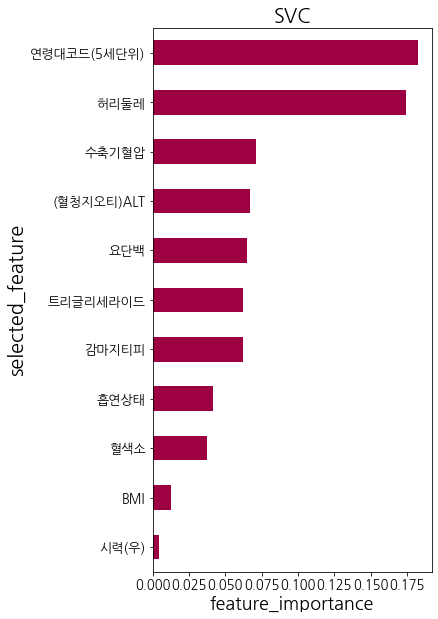

In [9]:
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False
feature_importance_df = pd.DataFrame(list(zip(selected_feature, grid.best_estimator_.coef_.tolist()[0])), columns=['selected_feature', 'feature_importance']).sort_values(by='feature_importance', ascending=True)
feature_importance_df = feature_importance_df.loc[feature_importance_df.feature_importance > 0]
feature_importance_df.plot.barh(x='selected_feature', y='feature_importance', figsize=(5,10), fontsize=13, legend=False, cmap = 'Spectral')
plt.title('SVC', fontsize=20)
plt.xlabel('feature_importance', fontsize=18)
plt.ylabel('selected_feature', fontsize=20)

In [10]:
feature_importance_df = pd.DataFrame(list(zip(selected_feature, grid.best_estimator_.coef_.tolist()[0])), columns=['selected_feature', 'feature_importance']).sort_values(by='feature_importance', ascending=True)
feature_importance_df = feature_importance_df.loc[feature_importance_df.feature_importance > 0].sort_values(by='feature_importance', ascending=False)
feature_importance_df

,selected_feature,feature_importance
2,연령대코드(5세단위),0.182870
5,허리둘레,0.174170
9,수축기혈압,0.071086
8,(혈청지오티)ALT,0.067045
1,요단백,0.064993
10,트리글리세라이드,0.062268
7,감마지티피,0.062109
3,흡연상태,0.041294
6,혈색소,0.037352
0,BMI,0.012738


In [11]:
final_model = grid.best_estimator_
print("Average recall score:", final_model.score(X_test_prepared, y_test))

y_pred = final_model.predict(X_test_prepared)
print(classification_report(y_test, y_pred))

Average recall score: 0.6623059633349723
              precision    recall  f1-score   support

         0.0       0.67      0.65      0.66     28474
         1.0       0.66      0.68      0.67     28474

    accuracy                           0.66     56948
   macro avg       0.66      0.66      0.66     56948
weighted avg       0.66      0.66      0.66     56948



#### (3) Random Forest(RF)

In [3]:
with tf.device('/gpu:0'):
    param_distribs = {
      'criterion': ['gini', 'entropy'],
      'max_depth': list(range(1, 10)),
      'max_features': ['auto', 'sqrt'],
      'max_leaf_nodes': list(range(1, 10)),
      'n_estimators': list(range(10, 100)),
      'min_samples_split': list(range(1, 10)),
      'min_samples_leaf': list(range(1, 10))
    }
    model = RandomForestClassifier()

    grid = RandomizedSearchCV(model, param_distributions=param_distribs, n_iter = 10, cv=5)
    grid.fit(X_train_prepared, y_train_prepared)
    RF_prob = grid.predict_proba(X_test_prepared)
    joblib.dump(grid.best_estimator_, './model/v1/RF_v1.pkl')
    print('optimal train score: {:.3f}'.format(grid.best_score_))
    print('test score: {:.3f}'.format(grid.score(X_test_prepared, y_test)))
    print('optimal parameter: {}'.format(grid.best_params_))

optimal train score: 0.773
test score: 0.659
optimal parameter: {'n_estimators': 99, 'min_samples_split': 7, 'min_samples_leaf': 3, 'max_leaf_nodes': 8, 'max_features': 'auto', 'max_depth': 3, 'criterion': 'gini'}


Text(0, 0.5, 'selected_feature')

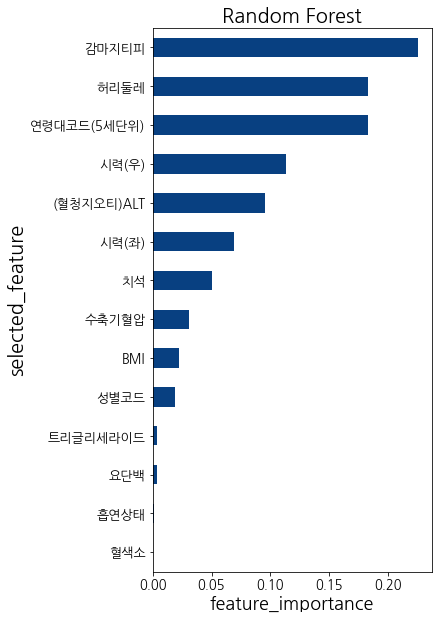

In [4]:
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False
feature_importance_df = pd.DataFrame(list(zip(selected_feature, (grid.best_estimator_.feature_importances_).tolist())), columns=['selected_feature', 'feature_importance']).sort_values(by='feature_importance', ascending=True)
feature_importance_df = feature_importance_df.loc[feature_importance_df.feature_importance > 0]
feature_importance_df.plot.barh(x='selected_feature', y='feature_importance', figsize=(5,10), fontsize=13, legend=False, cmap = 'GnBu_r')
plt.title('Random Forest', fontsize=20)
plt.xlabel('feature_importance', fontsize=18)
plt.ylabel('selected_feature', fontsize=20)

In [5]:
feature_importance_df = pd.DataFrame(list(zip(selected_feature, (grid.best_estimator_.feature_importances_).tolist())), columns=['selected_feature', 'feature_importance']).sort_values(by='feature_importance', ascending=True)
feature_importance_df = feature_importance_df.loc[feature_importance_df.feature_importance > 0].sort_values(by='feature_importance', ascending=False)
feature_importance_df

,selected_feature,feature_importance
7,감마지티피,0.225392
5,허리둘레,0.182672
2,연령대코드(5세단위),0.182407
11,시력(우),0.113342
8,(혈청지오티)ALT,0.095010
12,시력(좌),0.069180
4,치석,0.050358
9,수축기혈압,0.030495
0,BMI,0.022489
13,성별코드,0.019304


In [6]:
final_model = grid.best_estimator_
print("Average recall score:", final_model.score(X_test_prepared, y_test))

y_pred = final_model.predict(X_test_prepared)
print(classification_report(y_test, y_pred))

Average recall score: 0.6494170120109574
              precision    recall  f1-score   support

         0.0       0.65      0.64      0.65     28474
         1.0       0.65      0.66      0.65     28474

    accuracy                           0.65     56948
   macro avg       0.65      0.65      0.65     56948
weighted avg       0.65      0.65      0.65     56948



#### (4) LightGBM(LGB)

In [3]:
with tf.device('/gpu:0'):
    param_distribs = {
        'objective': ['binary'],
        'num_leaves': list(range(10, 100)),
        'n_estimators': list(range(100, 1000)),
        'class_weight': ['balanced', None]
    }
    model = lgb.LGBMClassifier()

    grid = RandomizedSearchCV(model, param_distributions=param_distribs, n_iter = 10, cv=10)
    grid.fit(X_train_prepared, y_train_prepared)
    LGB_prob = grid.predict_proba(X_test_prepared)
    joblib.dump(grid.best_estimator_, './model/v1/LGB_v1.pkl')
    
    print('optimal train score: {:.3f}'.format(grid.best_score_))
    print('test score: {:.3f}'.format(grid.score(X_test_prepared, y_test)))
    print('optimal parameter: {}'.format(grid.best_params_))

optimal train score: 0.945
test score: 0.509
optimal parameter: {'objective': 'binary', 'num_leaves': 87, 'n_estimators': 876, 'class_weight': None}


Text(0, 0.5, 'selected_feature')

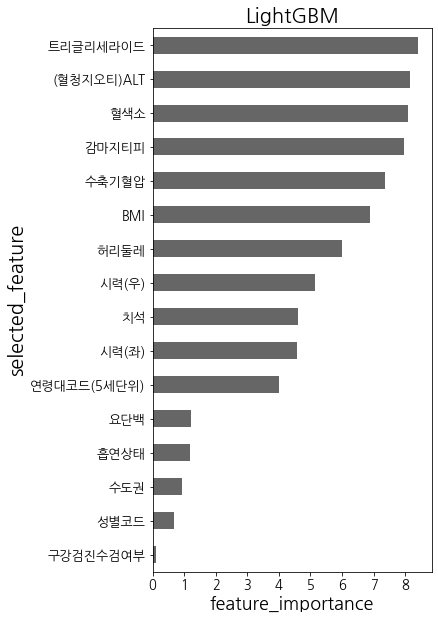

In [4]:
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False
feature_importance_df = pd.DataFrame(list(zip(selected_feature, (grid.best_estimator_.feature_importances_/1000).tolist())), columns=['selected_feature', 'feature_importance']).sort_values(by='feature_importance', ascending=True)
feature_importance_df = feature_importance_df.loc[feature_importance_df.feature_importance > 0]
feature_importance_df.plot.barh(x='selected_feature', y='feature_importance', figsize=(5,10), fontsize=13, legend=False, cmap = 'Accent_r')
plt.title('LightGBM', fontsize=20)
plt.xlabel('feature_importance', fontsize=18)
plt.ylabel('selected_feature', fontsize=20)

In [5]:
feature_importance_df = pd.DataFrame(list(zip(selected_feature, (grid.best_estimator_.feature_importances_/1000).tolist())), columns=['selected_feature', 'feature_importance']).sort_values(by='feature_importance', ascending=True)
feature_importance_df = feature_importance_df.loc[feature_importance_df.feature_importance > 0].sort_values(by='feature_importance', ascending=False)
feature_importance_df

,selected_feature,feature_importance
10,트리글리세라이드,8.414
8,(혈청지오티)ALT,8.164
6,혈색소,8.078
7,감마지티피,7.955
9,수축기혈압,7.375
0,BMI,6.881
5,허리둘레,6.013
11,시력(우),5.139
4,치석,4.600
12,시력(좌),4.574


In [6]:
final_model = grid.best_estimator_
print("Average recall score:", final_model.score(X_test_prepared, y_test))

y_pred = final_model.predict(X_test_prepared)
print(classification_report(y_test, y_pred))

Average recall score: 0.5093418557280326
              precision    recall  f1-score   support

         0.0       0.50      1.00      0.67     28474
         1.0       0.88      0.02      0.04     28474

    accuracy                           0.51     56948
   macro avg       0.69      0.51      0.36     56948
weighted avg       0.69      0.51      0.36     56948



#### (5) Multi-Layer Perceptron(MLP)

In [4]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [5]:
def get_model():
    model = Sequential()
    model.add(Dense(128, activation = 'relu', input_shape = (16,)))
    model.add(Dense(64, activation = 'relu'))
    model.add(Dense(16, activation = 'relu'))
    model.add(Dense(1, activation = 'sigmoid'))
    model.compile(optimizer = 'rmsprop', loss='binary_crossentropy', metrics=['acc',f1_m,precision_m, recall_m])
    return model

In [6]:
model = get_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               2176      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 16)                1040      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 11,489
Trainable params: 11,489
Non-trainable params: 0
_________________________________________________________________


In [7]:
with tf.device('/gpu:0'):
    # set model
    model = get_model()

    # split validation set
    train_test_split_idx = int(len(y_train_prepared) * .2)
    X_val = X_train_prepared[:train_test_split_idx]
    partial_X_train = X_train_prepared[train_test_split_idx:]
    y_val = y_train_prepared[:train_test_split_idx].astype('float32')
    partial_y_train = y_train_prepared[train_test_split_idx:].astype('float32')

    # fit model
    history = model.fit(partial_X_train, partial_y_train, epochs = 5, validation_data = (X_val, y_val)) 

Epoch 1/5
52625/52625 [==============================] - 128s 2ms/step - loss: 0.5835 - acc: 0.6909 - f1_m: 0.7012 - precision_m: 0.6719 - recall_m: 0.7486 - val_loss: 0.5748 - val_acc: 0.6971 - val_f1_m: 0.7128 - val_precision_m: 0.6697 - val_recall_m: 0.7760
Epoch 2/5
52625/52625 [==============================] - 126s 2ms/step - loss: 0.5789 - acc: 0.6974 - f1_m: 0.7073 - precision_m: 0.6778 - recall_m: 0.7549 - val_loss: 0.5805 - val_acc: 0.6974 - val_f1_m: 0.6958 - val_precision_m: 0.6902 - val_recall_m: 0.7156
Epoch 3/5
52625/52625 [==============================] - 128s 2ms/step - loss: 0.5802 - acc: 0.6988 - f1_m: 0.7077 - precision_m: 0.6801 - recall_m: 0.7530 - val_loss: 0.5832 - val_acc: 0.6990 - val_f1_m: 0.6927 - val_precision_m: 0.6974 - val_recall_m: 0.7019
Epoch 4/5
52625/52625 [==============================] - 129s 2ms/step - loss: 0.5813 - acc: 0.6996 - f1_m: 0.7093 - precision_m: 0.6804 - recall_m: 0.7561 - val_loss: 0.5909 - val_acc: 0.7002 - val_f1_m: 0.7173 - val

In [8]:
results = model.evaluate(X_test_prepared, y_test)
print(results)

1780/1780 [==============================] - 3s 1ms/step - loss: 0.6447 - acc: 0.6626 - f1_m: 0.4129 - precision_m: 0.5002 - recall_m: 0.3539
[0.6447400450706482, 0.6626220345497131, 0.41290679574012756, 0.5001652240753174, 0.3538529872894287]


In [12]:
model.save('./model/v1/MLP_v1.h5')

## ROC Curve

<Figure size 432x288 with 0 Axes>

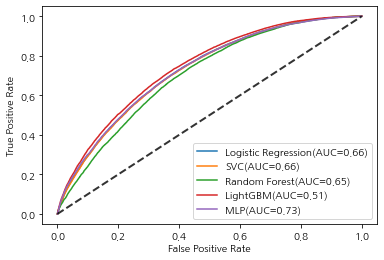

In [13]:
LR = joblib.load('./model/v1/LR_v1.pkl')
SVC = joblib.load('./model/v1/SVC_v1.pkl')
RF = joblib.load('./model/v1/RF_v1.pkl')
LGB = joblib.load('./model/v1/LGB_v1.pkl')
MLP = load_model('./model/v1/MLP_v1.h5')

LR_auc = roc_auc_score(y_test, LR.predict(X_test_prepared))
SVC_auc = roc_auc_score(y_test, SVC.predict(X_test_prepared))
RF_auc = roc_auc_score(y_test, RF.predict(X_test_prepared))
LGB_auc = roc_auc_score(y_test, LGB.predict(X_test_prepared))
MLP_auc = roc_auc_score(y_test, MLP.predict(X_test_prepared))

plt.figure(1)
LR_plot = plot_roc_curve(LR, X_test_prepared, y_test, label=f'Logistic Regression(AUC={LR_auc:.2f})')
SVC_plot = plot_roc_curve(SVC, X_test_prepared, y_test, ax=LR_plot.ax_, label=f'SVC(AUC={SVC_auc:.2f})')
RF_plot = plot_roc_curve(RF, X_test_prepared, y_test, ax=LR_plot.ax_, label=f'Random Forest(AUC={RF_auc:.2f})')
LGB_plot = plot_roc_curve(LGB, X_test_prepared, y_test, ax=LR_plot.ax_, label=f'LightGBM(AUC={LGB_auc:.2f})')
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, MLP.predict(X_test_prepared))
plt.plot(fpr_keras, tpr_keras, label=f'MLP(AUC={MLP_auc:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='black', alpha=.8)
plt.rcParams["figure.figsize"] = (10,10)
plt.legend(fontsize=10)